# Test validity : Variance $N_c^{1/2} \xi$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb

import non_parametric_ML_compsep as katame

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


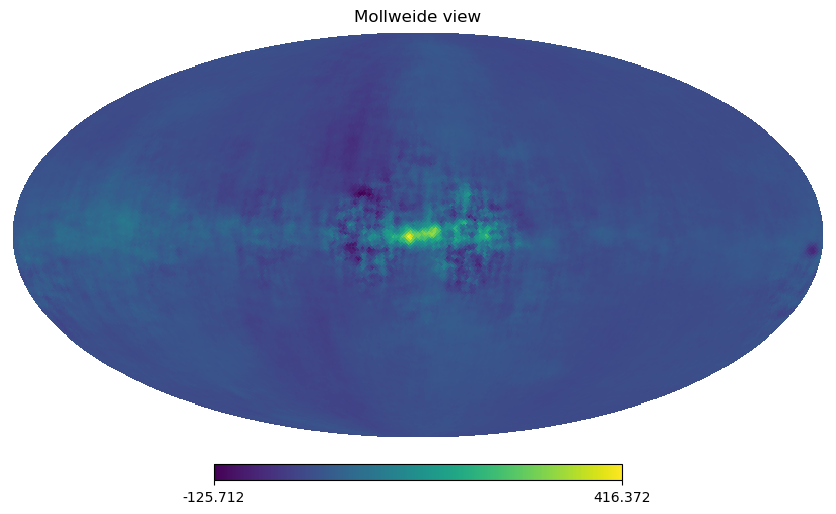

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
# lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
# c_ell_approx = np.zeros((6,lmax+1))
# c_ell_approx[1] = camb_cls.T[1]
# c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    # c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

In [8]:
# red_cov_approx_matrix = katame.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

In [9]:
depth_p = instrument['depth_p']

freq_inverse_noise = katame.get_noise_covar(depth_p, nside)

init_mixing_matrix_obj = katame.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = katame.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [10]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

In [11]:
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
# fluctuation_maps = katame.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

In [12]:
map_random_realization_chi_2 = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_components"],param_dict["nstokes"],12*param_dict["nside"]**2))


# calculated_map_1 = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_chi)[0] # Selecting CMB component of the random variable
calculated_map_1 = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_chi)[0] # Selecting CMB component of the random variable

calculated_map_2 = np.einsum('kc,csp->ksp', scipy.linalg.sqrtm(cp_cp_noise), map_random_realization_chi_2)[0] # Selecting CMB component of the random variable


# calculated_map_2 = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_chi)[0] # Selecting CMB component of the random variable

In [13]:
# initial_guess = np.zeros((nstokes,npix))
# wiener_filter_term = katame.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

In [14]:
fluctuation_term_extended = np.vstack([np.zeros_like(calculated_map_1[0]), calculated_map_1])
fluctuation_term_extended_2 = np.vstack([np.zeros_like(calculated_map_1[0]), calculated_map_2])
# wiener_filter_term_extended = np.vstack([np.zeros_like(wiener_filter_term[0]), wiener_filter_term])

c_ells_fluct_1 = hp.anafast(fluctuation_term_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
c_ells_fluct_2 = hp.anafast(fluctuation_term_extended_2, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# c_ells_WF = hp.anafast(wiener_filter_term_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [35]:
# # corr = 1/hp.nside2resol(nside)
# corr = 1#/hp.nside2resol(nside)

# # Analytical Fluctuating Term
# covariance_inverse_noise = np.zeros_like(c_ells_input[:,lmin:])
# covariance_inverse_noise[:nstokes,...] = np.linalg.pinv(cp_cp_noise*corr)[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]

covariance_noise_sqrt_not_corr = np.zeros_like(c_ells_input[:,lmin:])
# covariance_noise_sqrt_not_corr[:nstokes,...] = scipy.linalg.sqrtm(scipy.linalg.sqrtm(cp_cp_noise))[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]
covariance_noise_sqrt_not_corr[:nstokes,...] = cp_cp_noise[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]

# red_inv_noise = katame.get_reduced_matrix_from_c_ell(covariance_inverse_noise)

# red_inverse_cov_matrix = np.linalg.pinv(red_cov_matrix)
# red_inv_cov_sqrt = katame.get_sqrt_reduced_matrix_from_matrix(red_inverse_cov_matrix)


# # First right member : C^{-1/2} \xi
# right_member_1 = katame.maps_x_reduced_matrix_generalized_sqrt_sqrt(map_random_realization_xi, red_inv_cov_sqrt, lmin=lmin, n_iter=n_iter)

# ## Left hand side term : (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \chi
# right_member_2 = np.einsum('kc,cf,fsp->ksp', cp_cp_noise/hp.nside2resol(nside), cp_freq_inv_noise_sqrt, map_random_realization_chi)[0] # Selecting CMB component of the random variable

# right_member = (right_member_1 + right_member_2)#.ravel()

# # Computation of the left side member of the CG

# # Left hand side_term inverted and applied to right hand side term : (C^{-1} + N_c^{-1}) right_member
# left_member_inverted = np.linalg.pinv(red_inverse_cov_matrix + red_inv_noise*corr)
# # left_member_inverted = np.linalg.pinv(red_inverse_cov_matrix + red_inv_noise)
# analytical_fluct_maps = katame.maps_x_reduced_matrix_generalized_sqrt_sqrt(right_member, left_member_inverted, lmin=lmin, n_iter=n_iter)

In [36]:
# corr = 1/hp.nside2resol(nside)

# # Analytical WF Term
# covariance_inverse_noise = np.zeros_like(c_ells_input[:,lmin:])
# covariance_inverse_noise[:nstokes,...] = np.linalg.pinv(cp_cp_noise*corr)[0,0]*np.ones_like(c_ells_input)[:nstokes,lmin:]

# red_inv_noise = katame.get_reduced_matrix_from_c_ell(covariance_inverse_noise)

# red_inverse_cov_matrix = np.linalg.pinv(red_cov_matrix)
# red_inv_cov_sqrt = katame.get_sqrt_reduced_matrix_from_matrix(red_inverse_cov_matrix)

# # Computation of the right side member of the CG
# s_cML_extended = np.zeros((param_dict['number_components'], s_cML.shape[0], s_cML.shape[1]))
# s_cML_extended[0,...] = s_cML

# right_member = np.einsum('kc,csp->ksp', np.linalg.pinv(cp_cp_noise), s_cML_extended)[0] # Selecting CMB component of the

# # Computation of the left side member of the CG

# # Left hand side_term inverted and applied to right hand side term : (C^{-1} + N_c^{-1}) right_member
# left_member_inverted = np.linalg.pinv(red_inverse_cov_matrix + red_inv_noise)
# analytical_WF_maps = katame.maps_x_reduced_matrix_generalized_sqrt_sqrt(right_member, left_member_inverted, lmin=lmin, n_iter=n_iter)

In [37]:
extended_CG_fluct_maps = np.vstack([np.zeros_like(calculated_map_1[0]), calculated_map_1])
# extended_CG_WF_maps = np.vstack([np.zeros_like(wiener_filter_term[0]), wiener_filter_term])

# extended_analytical_fluct_maps = np.vstack([np.zeros_like(analytical_fluct_maps[0]), analytical_fluct_maps])
# extended_analytical_WF_maps = np.vstack([np.zeros_like(analytical_WF_maps[0]), analytical_WF_maps])

c_ells_fluct_CG = hp.anafast(extended_CG_fluct_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# c_ells_WF_CG = hp.anafast(extended_CG_WF_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

# c_ells_fluct_analytical = hp.anafast(extended_analytical_fluct_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# c_ells_WF_analytical = hp.anafast(extended_analytical_WF_maps, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [38]:
ell_arange = np.arange(c_ells_input.shape[1]) + lmin

In [39]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

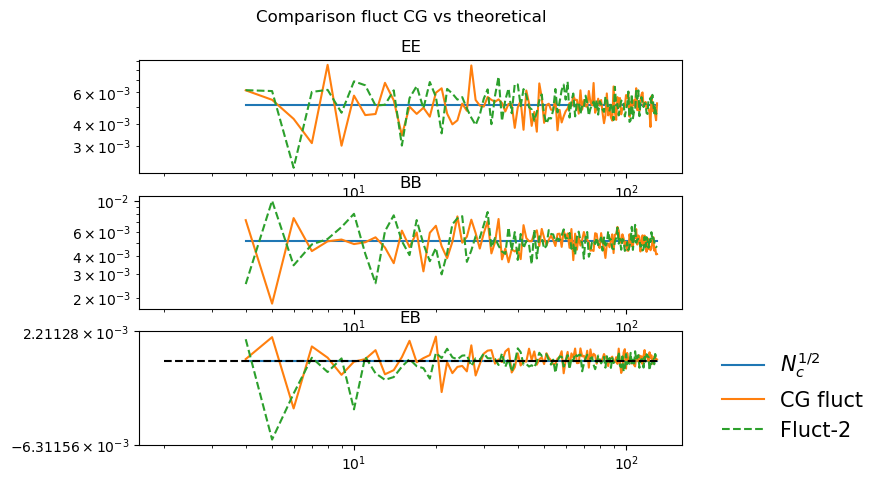

In [40]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison fluct CG vs theoretical")

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ells_input.T[:,j], label='CMB')
    plt.plot(ell_arange[lmin:], covariance_noise_sqrt_not_corr[j,:], label=r"$N_c^{1/2}$")
    # plt.plot(ell_arange[lmin:], noise[j,:], label=r"$\eta$ CG")

    plt.plot(ell_arange[lmin:], c_ells_fluct_CG[j,:], label=r"CG fluct")

    plt.plot(ell_arange[lmin:], c_ells_fluct_2[j,:], '--', label=r"Fluct-2")
    
    # plt.plot(ell_arange[lmin:], c_ells_fluct_analytical[j,:], '-.', label=r"analytical Fluct")

    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()

In [41]:
# # list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
# list_correl = ['EE', 'BB', 'EB']


# plt.figure(figsize=(7,5))
# plt.suptitle(r"Comparison WF CG vs theoretical")

# for j in range(number_correl_to_plot):
#     ax = plt.subplot(311+j)
#     plt.title(list_correl[j])

#     plt.plot(ell_arange, c_ells_input.T[:,j], label='CMB')
#     # plt.plot(ell_arange[lmin:], noise[j,:], label=r"$\eta$ CG")

#     plt.plot(ell_arange[lmin:], c_ells_WF_CG[j,:], label=r"CG WF")
    
#     plt.plot(ell_arange[lmin:], c_ells_WF_analytical[j,:], '-.', label=r"analytical WF")
    
#     plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
#     if nstokes == 3 and j < number_correl_to_plot-2:
#         plt.xticks(color='w')

#     if j <= nstokes-1:
#         plt.loglog()
#         # plt.ylim(ymin=noise_level/10.)
#     else:
#         plt.xscale('log')
#         plt.yscale('symlog')
#     # plt.legend()
#     if j == position_legend:
#         plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


# plt.show()